In [108]:
import cv2 as cv
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import ImageEnhance, Image
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import load_model
from keras.optimizers import SGD

Using TensorFlow backend.


In [26]:
tf.set_random_seed(0)

In [291]:
position_to_char = {0:'A', 1:'B', 2:'C', 3:'D'}
position_to_variant = {0:'I', 1:'F'}

• Scenario 1 

In [275]:
def find_rows(grayscale_image):
    edges_y = cv.Sobel(grayscale_image, ddepth=cv.CV_64F, dx=0, dy=1) 
    edges_y = np.abs(edges_y)
    edges_y = edges_y / edges_y.max()
    
    _, edges_y_th = cv.threshold(edges_y, 0.45, 255, cv.THRESH_BINARY_INV) 

        
    mask = (edges_y_th == 0) * 1
    all_lines = np.sum(mask, axis=1)

    all_lines = all_lines.argsort()
    
    num_lines = 100
    edges_y_th = np.dstack((edges_y_th, edges_y_th, edges_y_th))
    lines = [] #  _ x 
    for i in range(1, num_lines + 1):
        cv.line(edges_y_th, (0, all_lines[-i]), (grayscale_image.shape[1], all_lines[-i]), (0, 0, 255), 2) 
        lines.append([(0, all_lines[-i]), (grayscale_image.shape[1], all_lines[-i])])
    
    lines.sort(key=lambda coords: coords[0][1])
    
    threshold_same_line = 30
    distict_lines = []   
    distict_lines.append(lines[0])
     
    for line in lines:  
        if line[0][1] - distict_lines[-1][0][1] > threshold_same_line:
            distict_lines.append(line)   

    correct_lines = distict_lines[-16:]
    color_image = np.dstack((grayscale_image, grayscale_image, grayscale_image))
    for line in correct_lines: 
        cv.line(color_image, line[0], line[1], (255, 0, 0), 5) 
    
    return correct_lines

In [276]:
def find_columns(grayscale_image):

    edges_x = cv.Sobel(grayscale_image, ddepth=cv.CV_64F, dx=1, dy=0) 
    edges_x = np.abs(edges_x)
    edges_x = edges_x / edges_x.max()

    _, edges_x_th = cv.threshold(edges_x, 0.45, 255, cv.THRESH_BINARY_INV) 
    mask = (edges_x_th == 0) * 1
    
    all_cols = np.sum(mask, axis=0)
    all_cols = all_cols.argsort()
    
    num_cols = 40

    edges_x_th = np.dstack((edges_x_th, edges_x_th, edges_x_th))
    cols = [] 
    for i in range(1, num_cols + 1):
        cv.line(edges_x_th, (all_cols[-i], 0), (all_cols[-i], grayscale_image.shape[0]), (0, 0, 255), 2)
        cols.append([(all_cols[-i], 0), (all_cols[-i], grayscale_image.shape[0])])   
    
    cols.sort(key=lambda coords: coords[0][0])
    threshold_same_column = 30
    distinct_cols = []
    distinct_cols.append(cols[0])
    
    for col in cols:  
        if col[0][0] - distinct_cols[-1][0][0] > threshold_same_column:
            distinct_cols.append(col) 
    

    correct_cols = distinct_cols[-5:]
    color_image = np.dstack((grayscale_image, grayscale_image, grayscale_image))
    for col in correct_cols: 
        cv.line(color_image, col[0], col[1], (255, 0, 0), 5) 
        
    return correct_cols

In [284]:
def find_table(grayscale_image):
    cols = find_columns(grayscale_image.copy())
    rows = find_rows(grayscale_image.copy())
        
    x_min = cols[0][0][0]
    x_max = cols[-1][1][0]
    y_min = rows[0][0][1]
    y_max = rows[-1][1][1]
  
   
    table = grayscale_image[y_min:y_max, x_min:x_max] 
    image = np.dstack((grayscale_image, grayscale_image, grayscale_image))

    answers={}
    for i in range(len(rows) - 1):
        line_mean=[]
        for j in range(len(cols) - 1):
            
            x_mmin = cols[j][0][0] + 15
            x_mmax = cols[j + 1][1][0] - 5
            y_mmin = rows[i][0][1] + 15
            y_mmax = rows[i + 1][1][1] - 5

            patch = grayscale_image[y_mmin:y_mmax, x_mmin:x_mmax]

            mean_patch = np.round(patch.mean())
            line_mean.append(mean_patch)     
        ans=np.argmin(line_mean)
        answers[i+1]=position_to_char[ans]
                
    cv.waitKey(0)
    cv.destroyAllWindows()  
    return table, answers

In [285]:
def extract_answers(image):
    grayscale_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    cv.imwrite('image.jpg', grayscale_image)
    orig_h, orig_w = grayscale_image.shape  
    grayscale_image = grayscale_image[int(0.52 * orig_h):-int(0.12 * orig_h)] 
    left_image = grayscale_image[:, :int(orig_w * 0.5)]
    right_image = grayscale_image[:, int(orig_w * 0.5):]
    
    table, ans_left = find_table(left_image)
   
    table, ans_right = find_table(right_image)

    print(ans_left)
    print(ans_right)
    return ans_left, ans_right

In [286]:
def rotate_image(img_template, img_query):
    orb = cv.ORB_create(nfeatures=15000)
    kp_template, des_template  = orb.detectAndCompute(img_template, None)
    kp_query, des_query= orb.detectAndCompute(img_query, None) 
    
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des_query, des_template) 
    matches = sorted(matches, key = lambda x:x.distance)

    points_template = np.zeros((len(matches), 2))
    points_query = np.zeros((len(matches), 2))

    for i, match in enumerate(matches):
        points_template[i, :] = kp_template[match.trainIdx].pt
        points_query[i, :] = kp_query[match.queryIdx].pt
        
    M, mask = cv.findHomography(points_query, points_template, cv.RANSAC)
    height, width, _ = img_template.shape
    aligned_image2 = cv.warpPerspective(img_query, M, (width, height), flags=cv.INTER_NEAREST)

    return aligned_image2

In [287]:
def extract_answers(image):
    grayscale_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    orig_h, orig_w = grayscale_image.shape  
    grayscale_image = grayscale_image[int(0.54 * orig_h):-int(0.12 * orig_h)] 
    left_image = grayscale_image[:, :int(orig_w * 0.45)]
    right_image = grayscale_image[:, int(orig_w * 0.5):int(orig_w * 0.92)]
    
    table, ans_left = find_table(left_image)
   
    table, ans_right = find_table(right_image)

    print(ans_left)
    print(ans_right)
    return ans_left, ans_right

In [288]:
#https://stackoverflow.com/questions/53885575/how-to-add-multiple-effects-to-a-picture-such-as-contrast-and-brightness-at-the

def converted_image(original_image, contrast, brightness,color, sharpness):
        contrast_converter = ImageEnhance.Contrast(original_image)
        image_contrasted = contrast_converter.enhance(contrast)
        brightness_converter = ImageEnhance.Brightness(image_contrasted)
        image_brigthened = brightness_converter.enhance(brightness)
        color_converter = ImageEnhance.Color(image_brigthened)
        image_coloured= color_converter.enhance(color)
        sharpness_converter = ImageEnhance.Sharpness(image_coloured)
        image_converted = sharpness_converter.enhance(sharpness)
        return image_converted

In [289]:
#100% scanned, 98% perspective, 99.3% rotated
def answers_left_right(images_names, img_template_name):
    answers_left=[]
    answers_right=[]
    img_template = cv.imread(img_template_name )
    img_template = cv.cvtColor(img_template, cv.COLOR_BGR2RGB)
    dim = (1300, 2000)
    resized = cv.resize(img_template, dim,interpolation = cv.INTER_AREA)
    for image_name in images_names: 
        try:
            img_query = cv.imread(image_name)
            rotated_image=rotate_image(resized, img_query)
            im_pil = Image.fromarray(rotated_image)
            converted_img=converted_image(im_pil, 6, 4, 4, 8)
            open_cv_image = np.array(converted_img) 

            ans_left, ans_right=extract_answers(open_cv_image)
            answers_left.append(ans_left)
            answers_right.append(ans_right)
        except:
            print("Couldn't find image")
    return answers_left, answers_right

In [290]:
def calculate_grades(images_names,images_answers_left, images_answers_right,output_file_name, files_info, files_fizica):

    file = open(output_file_name, "w")

    for i in range(len(images_names)):
        try:
            begin_nr = images_names[i].find('\\')+1
            end_nr = images_names[i].find('_', begin_nr)
            r_number=images_names[i][begin_nr:end_nr]
            nr_template=int(r_number)

            begin_var=images_names[i].find('_')+1
            end_var = images_names[i].find('.', begin_var)
            r_variant=images_names[i][begin_var:end_var]
            r_type=r_variant.split('_')[-1]
            print('Varianta')
            print(r_type)

            correct_answers=0
            ans_left_c=[]
            ans_right_c=[]
            if r_type[0]=='F':
                if r_type[1]=='1':
                    ans_left_c=files_fizica[0][1:16]
                    ans_right_c=files_fizica[0][16:-1]
                if r_type[1]=='2':
                    ans_left_c=files_fizica[1][1:16]
                    ans_right_c=files_fizica[1][16:-1]
                if r_type[1]=='3':
                    ans_left_c=files_fizica[2][1:16]
                    ans_right_c=files_fizica[2][16:-1]
                if r_type[1]=='4':
                    ans_left_c=files_fizica[3][1:16]
                    ans_right_c=files_fizica[3][16:-1]
            if r_type[0]=='I':
                if r_type[1]=='1':
                    ans_left_c=files_info[0][1:16]
                    ans_right_c=files_info[0][16:-1]
                if r_type[1]=='2':
                    ans_left_c=files_info[1][1:16]
                    ans_right_c=files_info[1][16:-1]
                if r_type[1]=='3':
                    ans_left_c=files_info[2][1:16]
                    ans_right_c=files_info[2][16:-1]
                if r_type[1]=='4':
                    ans_left_c=files_info[3][1:16]
                    ans_right_c=files_info[3][16:-1]


            for j in range(len(images_answers_left[i])):
                if images_answers_left[i][j+1]==ans_left_c[j][1]:
                    correct_answers+=1
            for j in range(len(images_answers_right[i])):
                if images_answers_right[i][j+1]==ans_right_c[j][1]:
                    correct_answers+=1

            print('The number of correct answers from exam image %d are %d '%(i+1,correct_answers))
            grade=round(correct_answers*0.3 +1,2)
            print('Grade: %5.2f'%(grade))

            file_name=images_names[i].split('\\')[-1]
            file.write(file_name + "  " + str(grade) + "\n")
        except:
            print("Error occured")

    file.close()

In [158]:
ans_folder='ground-truth-answers'
list_fizica = glob.glob(os.path.join(ans_folder, "Fizica_varianta*.txt")) 
print(list_fizica)
files_fizica=[]
for i in range(len( list_fizica)):
    files_fizica.append(np.loadtxt(list_fizica[i], dtype=str))

list_info = glob.glob(os.path.join(ans_folder, "Informatica_varianta*.txt")) 
print(list_info)
files_info=[]
for i in range(len(list_info)):
    files_info.append(np.loadtxt(list_info[i], dtype=str))

['ground-truth-answers\\Fizica_varianta1.txt', 'ground-truth-answers\\Fizica_varianta2.txt', 'ground-truth-answers\\Fizica_varianta3.txt', 'ground-truth-answers\\Fizica_varianta4.txt']
['ground-truth-answers\\Informatica_varianta1.txt', 'ground-truth-answers\\Informatica_varianta2.txt', 'ground-truth-answers\\Informatica_varianta3.txt', 'ground-truth-answers\\Informatica_varianta4.txt']


In [159]:
base_folder='1.scanned/'
img_template_name='template.jpg'
images_names = glob.glob(os.path.join(base_folder, "*_scanned_*.jpg")) 
images_names.sort(key = len) 

In [160]:
images_names

['1.scanned\\56_scanned_F2.jpg',
 '1.scanned\\57_scanned_F1.jpg',
 '1.scanned\\58_scanned_I1.jpg',
 '1.scanned\\59_scanned_I2.jpg',
 '1.scanned\\60_scanned_I3.jpg']

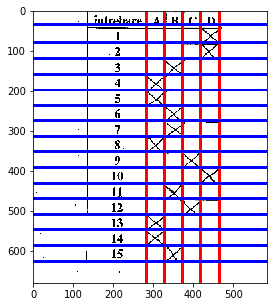

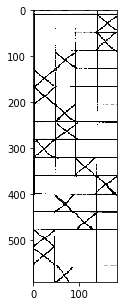

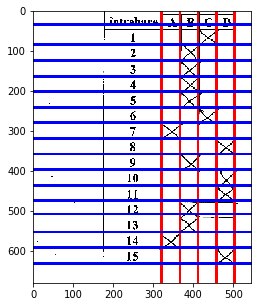

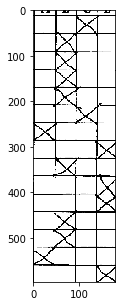

{1: 'D', 2: 'D', 3: 'B', 4: 'A', 5: 'A', 6: 'B', 7: 'B', 8: 'A', 9: 'C', 10: 'D', 11: 'B', 12: 'C', 13: 'A', 14: 'A', 15: 'B'}
{1: 'C', 2: 'B', 3: 'B', 4: 'B', 5: 'B', 6: 'C', 7: 'A', 8: 'D', 9: 'B', 10: 'D', 11: 'D', 12: 'B', 13: 'B', 14: 'A', 15: 'D'}


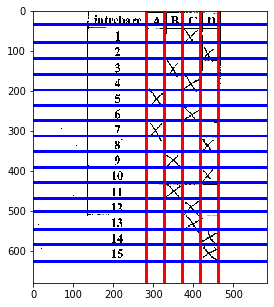

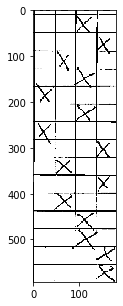

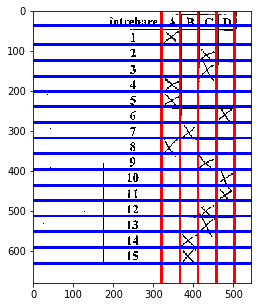

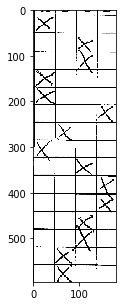

{1: 'C', 2: 'D', 3: 'B', 4: 'C', 5: 'A', 6: 'C', 7: 'A', 8: 'D', 9: 'B', 10: 'D', 11: 'B', 12: 'C', 13: 'C', 14: 'D', 15: 'D'}
{1: 'A', 2: 'C', 3: 'C', 4: 'A', 5: 'A', 6: 'D', 7: 'B', 8: 'A', 9: 'C', 10: 'D', 11: 'D', 12: 'C', 13: 'C', 14: 'B', 15: 'B'}


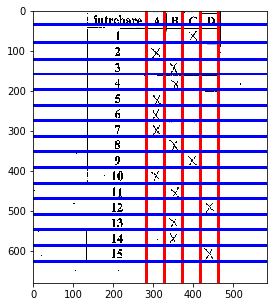

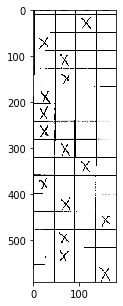

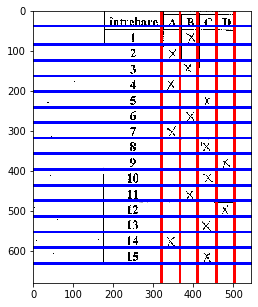

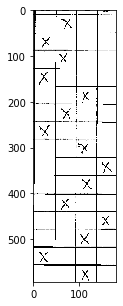

{1: 'C', 2: 'A', 3: 'B', 4: 'B', 5: 'A', 6: 'A', 7: 'A', 8: 'B', 9: 'C', 10: 'A', 11: 'B', 12: 'D', 13: 'B', 14: 'B', 15: 'D'}
{1: 'B', 2: 'A', 3: 'B', 4: 'A', 5: 'C', 6: 'B', 7: 'A', 8: 'C', 9: 'D', 10: 'C', 11: 'B', 12: 'D', 13: 'C', 14: 'A', 15: 'C'}


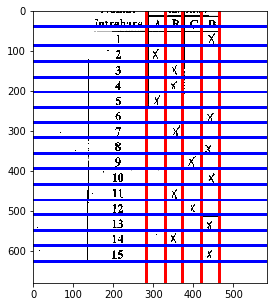

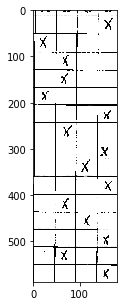

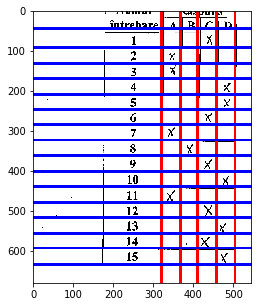

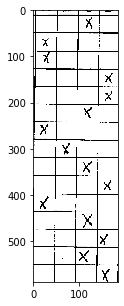

{1: 'D', 2: 'A', 3: 'B', 4: 'B', 5: 'A', 6: 'D', 7: 'B', 8: 'D', 9: 'C', 10: 'D', 11: 'B', 12: 'C', 13: 'D', 14: 'B', 15: 'D'}
{1: 'C', 2: 'A', 3: 'A', 4: 'D', 5: 'D', 6: 'C', 7: 'A', 8: 'B', 9: 'C', 10: 'D', 11: 'A', 12: 'C', 13: 'D', 14: 'C', 15: 'D'}


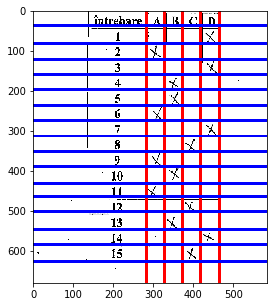

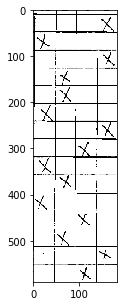

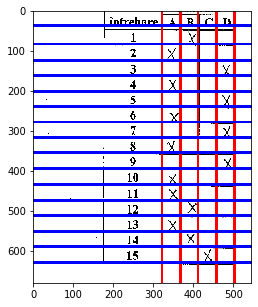

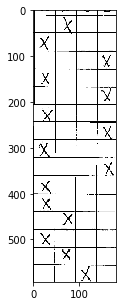

{1: 'D', 2: 'A', 3: 'D', 4: 'B', 5: 'B', 6: 'A', 7: 'D', 8: 'C', 9: 'A', 10: 'B', 11: 'A', 12: 'C', 13: 'B', 14: 'D', 15: 'C'}
{1: 'B', 2: 'A', 3: 'D', 4: 'A', 5: 'D', 6: 'A', 7: 'D', 8: 'A', 9: 'D', 10: 'A', 11: 'A', 12: 'B', 13: 'A', 14: 'B', 15: 'C'}
Varianta
F2
The number of correct answers from exam image 1 are 15 
Grade:  5.50
Varianta
F1
The number of correct answers from exam image 2 are 22 
Grade:  7.60
Varianta
I1
The number of correct answers from exam image 3 are 15 
Grade:  5.50
Varianta
I2
The number of correct answers from exam image 4 are 18 
Grade:  6.40
Varianta
I3
The number of correct answers from exam image 5 are 18 
Grade:  6.40


In [263]:

answers_left, answers_right=answers_left_right(images_names, img_template_name)
calculate_grades(images_names,answers_left, answers_right,'task1.txt', files_info, files_fizica)


• Scenario 2  - you receive a test set containing 50 rotated and 50 perspective images annotated with the view (rotated or perspective), the option (F or
I) and the digit (1, 2, 3 or 4). For each image you have to output the corresponding
grade. 

In [93]:
ans_folder='2.rotated+perspective'
rotated_persp_images = glob.glob(os.path.join(ans_folder, "*_*_*.jpg")) 
rotated_persp_images.sort(key = len) 
img_template_name='template.jpg'

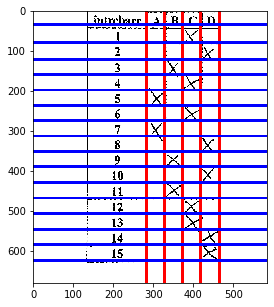

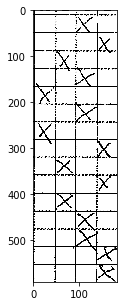

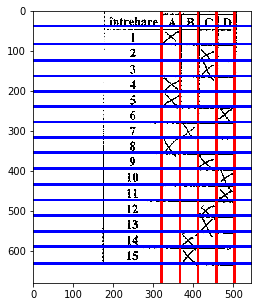

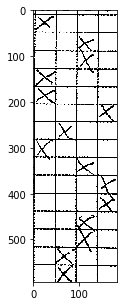

{1: 'C', 2: 'D', 3: 'B', 4: 'C', 5: 'A', 6: 'C', 7: 'A', 8: 'D', 9: 'B', 10: 'D', 11: 'B', 12: 'C', 13: 'C', 14: 'D', 15: 'D'}
{1: 'A', 2: 'C', 3: 'C', 4: 'A', 5: 'A', 6: 'D', 7: 'B', 8: 'A', 9: 'C', 10: 'D', 11: 'D', 12: 'C', 13: 'C', 14: 'B', 15: 'B'}


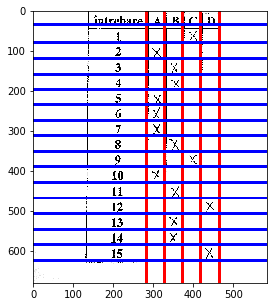

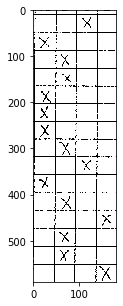

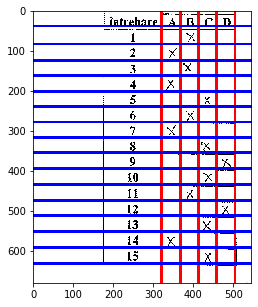

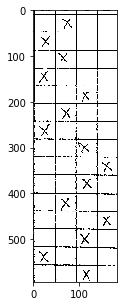

{1: 'C', 2: 'A', 3: 'B', 4: 'B', 5: 'A', 6: 'A', 7: 'A', 8: 'B', 9: 'C', 10: 'A', 11: 'B', 12: 'D', 13: 'B', 14: 'B', 15: 'D'}
{1: 'B', 2: 'A', 3: 'B', 4: 'A', 5: 'C', 6: 'B', 7: 'A', 8: 'C', 9: 'D', 10: 'C', 11: 'B', 12: 'D', 13: 'C', 14: 'A', 15: 'C'}


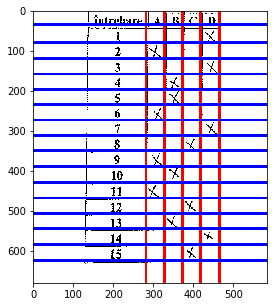

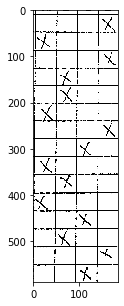

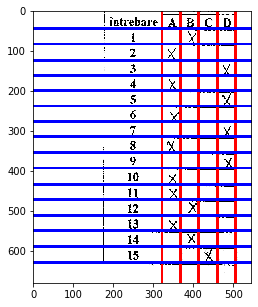

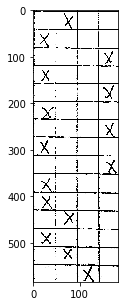

{1: 'D', 2: 'A', 3: 'D', 4: 'B', 5: 'B', 6: 'A', 7: 'D', 8: 'C', 9: 'A', 10: 'B', 11: 'A', 12: 'C', 13: 'B', 14: 'D', 15: 'C'}
{1: 'B', 2: 'A', 3: 'D', 4: 'A', 5: 'D', 6: 'A', 7: 'D', 8: 'A', 9: 'D', 10: 'A', 11: 'A', 12: 'B', 13: 'A', 14: 'B', 15: 'C'}


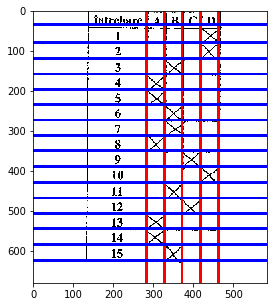

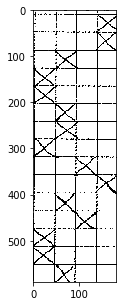

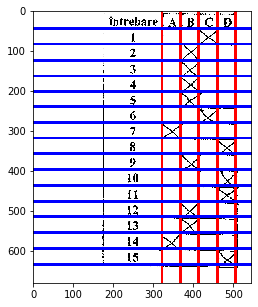

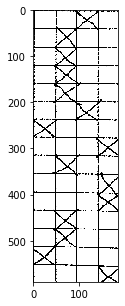

{1: 'D', 2: 'D', 3: 'B', 4: 'A', 5: 'A', 6: 'B', 7: 'B', 8: 'A', 9: 'C', 10: 'D', 11: 'B', 12: 'C', 13: 'A', 14: 'A', 15: 'B'}
{1: 'C', 2: 'B', 3: 'B', 4: 'B', 5: 'B', 6: 'C', 7: 'A', 8: 'D', 9: 'B', 10: 'D', 11: 'D', 12: 'B', 13: 'B', 14: 'A', 15: 'D'}


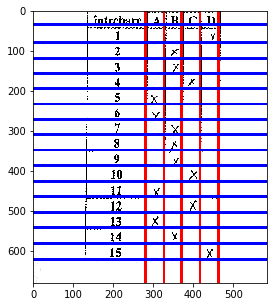

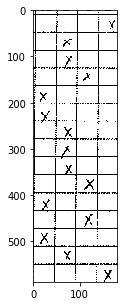

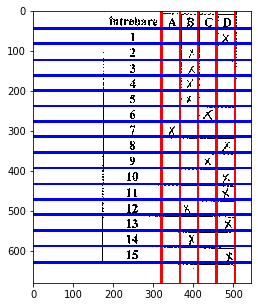

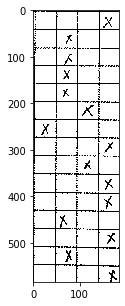

{1: 'D', 2: 'B', 3: 'B', 4: 'C', 5: 'A', 6: 'A', 7: 'B', 8: 'B', 9: 'B', 10: 'C', 11: 'A', 12: 'C', 13: 'A', 14: 'B', 15: 'D'}
{1: 'D', 2: 'B', 3: 'B', 4: 'B', 5: 'B', 6: 'C', 7: 'A', 8: 'D', 9: 'C', 10: 'D', 11: 'D', 12: 'B', 13: 'D', 14: 'B', 15: 'D'}


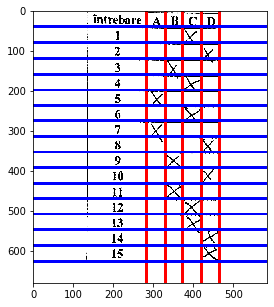

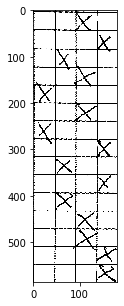

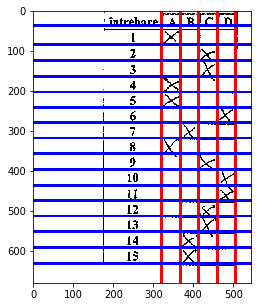

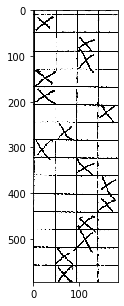

{1: 'C', 2: 'D', 3: 'B', 4: 'C', 5: 'A', 6: 'C', 7: 'A', 8: 'D', 9: 'B', 10: 'D', 11: 'B', 12: 'C', 13: 'C', 14: 'D', 15: 'D'}
{1: 'A', 2: 'C', 3: 'C', 4: 'A', 5: 'A', 6: 'D', 7: 'B', 8: 'A', 9: 'C', 10: 'D', 11: 'D', 12: 'C', 13: 'C', 14: 'B', 15: 'B'}


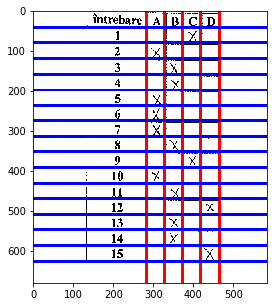

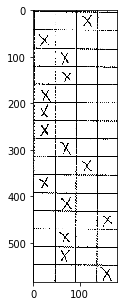

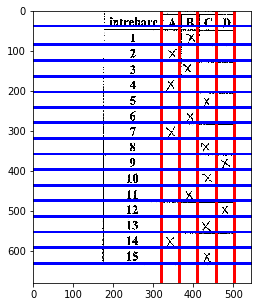

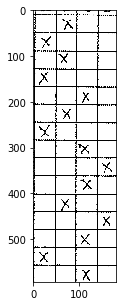

{1: 'C', 2: 'A', 3: 'B', 4: 'B', 5: 'A', 6: 'A', 7: 'A', 8: 'B', 9: 'C', 10: 'A', 11: 'B', 12: 'D', 13: 'B', 14: 'B', 15: 'D'}
{1: 'B', 2: 'A', 3: 'B', 4: 'A', 5: 'C', 6: 'B', 7: 'A', 8: 'C', 9: 'D', 10: 'C', 11: 'B', 12: 'D', 13: 'C', 14: 'A', 15: 'C'}


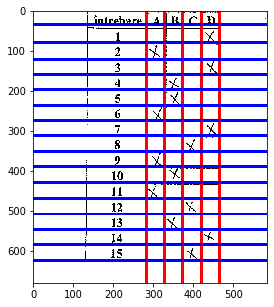

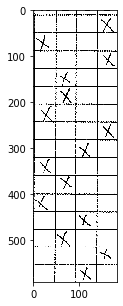

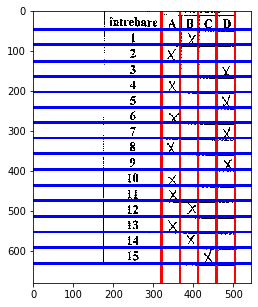

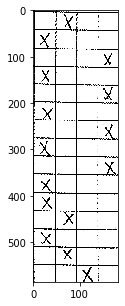

{1: 'D', 2: 'A', 3: 'D', 4: 'B', 5: 'B', 6: 'A', 7: 'D', 8: 'C', 9: 'A', 10: 'B', 11: 'A', 12: 'C', 13: 'B', 14: 'D', 15: 'C'}
{1: 'B', 2: 'A', 3: 'D', 4: 'A', 5: 'D', 6: 'A', 7: 'D', 8: 'A', 9: 'D', 10: 'A', 11: 'A', 12: 'B', 13: 'A', 14: 'B', 15: 'C'}


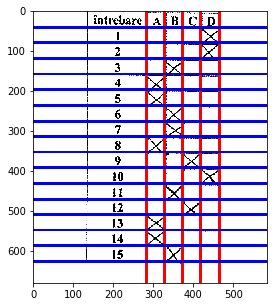

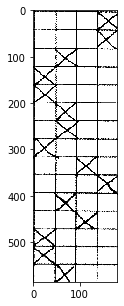

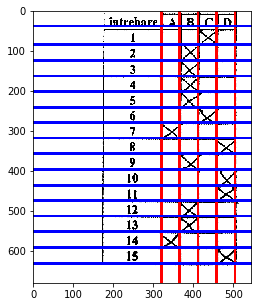

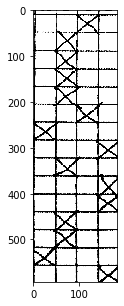

{1: 'D', 2: 'D', 3: 'B', 4: 'A', 5: 'A', 6: 'B', 7: 'B', 8: 'A', 9: 'C', 10: 'D', 11: 'B', 12: 'C', 13: 'A', 14: 'A', 15: 'B'}
{1: 'C', 2: 'B', 3: 'B', 4: 'B', 5: 'B', 6: 'C', 7: 'A', 8: 'D', 9: 'B', 10: 'D', 11: 'D', 12: 'B', 13: 'B', 14: 'A', 15: 'D'}


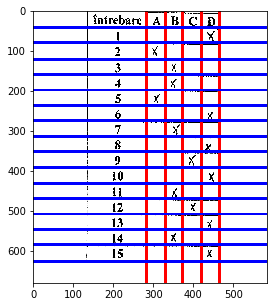

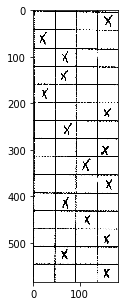

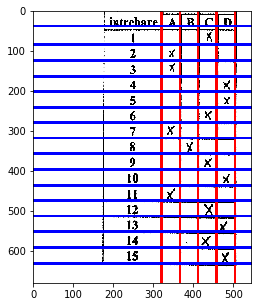

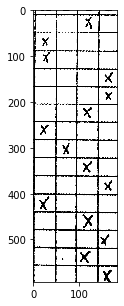

{1: 'D', 2: 'A', 3: 'B', 4: 'B', 5: 'A', 6: 'D', 7: 'B', 8: 'D', 9: 'C', 10: 'D', 11: 'B', 12: 'C', 13: 'D', 14: 'B', 15: 'D'}
{1: 'C', 2: 'A', 3: 'A', 4: 'D', 5: 'D', 6: 'C', 7: 'A', 8: 'B', 9: 'C', 10: 'D', 11: 'A', 12: 'C', 13: 'D', 14: 'C', 15: 'D'}
Varianta
F1
The number of correct answers from exam image 1 are 22 
Grade:  7.60
Varianta
I1
The number of correct answers from exam image 2 are 15 
Grade:  5.50
Varianta
I3
The number of correct answers from exam image 3 are 18 
Grade:  6.40
Varianta
F2
The number of correct answers from exam image 4 are 15 
Grade:  5.50
Varianta
F2
The number of correct answers from exam image 5 are 13 
Grade:  4.90
Varianta
F1
The number of correct answers from exam image 6 are 22 
Grade:  7.60
Varianta
I1
The number of correct answers from exam image 7 are 15 
Grade:  5.50
Varianta
I3
The number of correct answers from exam image 8 are 18 
Grade:  6.40
Varianta
F2
The number of correct answers from exam image 9 are 15 
Grade:  5.50
Varianta
I2
The n

In [265]:
answers_left_r, answers_right_r=answers_left_right(rotated_persp_images, img_template_name)
calculate_grades(rotated_persp_images,answers_left_r, answers_right_r,'task2.txt', files_info, files_fizica)


• Scenario 3 (no annotations) - you receive a test set containing 75 images (scanned, rotated or perspective view). There is no annotation available. For each image you
have to output the corresponding grade.

In [97]:
def find_subject_choice(choice_patch_grayscale):

    mask = np.uint8(choice_patch_grayscale < 50)
    contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)    
    areas = []
    coords = []    
    if len(contours) != 0:
        for idx_det in range(len(contours)):
            contour = contours[idx_det] 
            contour = np.squeeze(contour)  
            
            if contour.ndim == 1:
                continue
            x_min = np.min(contour[:, 0])
            x_max = np.max(contour[:, 0])

            y_min = np.min(contour[:, 1])
            y_max = np.max(contour[:, 1])
            
            areas.append(((x_max - x_min) * (y_max - y_min)))
            coords.append([(x_min, y_min), (x_max, y_max)])
            
    if len(areas) < 2:
        return None
    
    areas = np.array(areas)
    indices = areas.argsort()

    bbox_1 = coords[indices[-1]]
    bbox_2 = coords[indices[-2]]
    return bbox_1, bbox_2

In [99]:
def find_variant(right_grayscale_image):
    cols_right=find_columns(right_grayscale_image.copy())
    rows_right=find_rows(right_grayscale_image.copy())
    x_min = cols_right[-2][0][0]
    x_max = cols_right[-1][0][0]
    y_min = 100
    y_max = rows_right[0][1][1]-80
    
    patches=[]
    patch= right_grayscale_image[y_min:y_max, x_min:x_max]
        
    bbox_1, bbox_2 = find_subject_choice(patch.copy())
    choice_patch_color = np.dstack((patch, patch, patch))

    x_mmin1 = bbox_1[0][0] + 2
    x_mmax1 = bbox_1[1][0] - 2
    y_mmin1 = bbox_1[0][1] + 2
    y_mmax1 = bbox_1[1][1] - 2
    patch1=choice_patch_color[ y_mmin1:y_mmax1,x_mmin1:x_mmax1]
    x_mmin2 = bbox_2[0][0] + 2
    x_mmax2 = bbox_2[1][0] - 2
    y_mmin2 = bbox_2[0][1] + 2
    y_mmax2 = bbox_2[1][1] - 2
    patch2=choice_patch_color[ y_mmin2:y_mmax2,x_mmin2:x_mmax2]
    patches_mean=[]
    mean_patch1 = np.round(patch1.mean())
    mean_patch2 = np.round(patch2.mean())
    if(y_mmax1>y_mmax2):
        patches.append(patch2)
        patches.append(patch1)
        patches_mean.append(mean_patch2)     
        patches_mean.append(mean_patch1) 
    if(y_mmax2>y_mmax1):
        patches.append(patch1)
        patches.append(patch2)
        patches_mean.append(mean_patch1)     
        patches_mean.append(mean_patch2) 
        
    ans=np.argmin(patches_mean)
    chosen_patch=patches[ans]
    return chosen_patch, ans 

In [292]:
def extract_variant_no_ann(image1, image2):
    grayscale_image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
    orig_h, orig_w = grayscale_image1.shape
    grayscale_image1 = grayscale_image1[int(0.54 * orig_h):-int(0.12 * orig_h)] 
    left_image = grayscale_image1[:, :int(orig_w * 0.45)]
    right_image = grayscale_image1[:, int(orig_w * 0.5):int(orig_w * 0.92)]

    grayscale_image2=cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
    grayscale_image2 = grayscale_image2[int(0.40 * orig_h):-int(0.12 * orig_h)] 
    orig_h2, orig_w2 = grayscale_image2.shape
    right_image2 = grayscale_image2[:, int(orig_w2 * 0.5):int(orig_w2 * 0.93)]
    chosen_patch, s=find_variant(right_image2.copy())
    subject=position_to_variant[s]
    print(subject)

    table, ans_left = find_table(left_image)
   
    table, ans_right = find_table(right_image)

    print(ans_left)
    print(ans_right)
    return ans_left, ans_right, chosen_patch, subject

In [293]:
def answers_left_right_no_ann(images_names, img_template_name):
    answers_left_ann=[]
    answers_right_ann=[]
    subjects=[]
    chosen_variant=[]
    img_template = cv.imread(img_template_name )
    img_template = cv.cvtColor(img_template, cv.COLOR_BGR2RGB)
    dim = (1300, 2000)
    resized = cv.resize(img_template, dim,interpolation = cv.INTER_AREA)
    for image_name in images_names: 
        try:
            img_query = cv.imread(image_name)
            rotated_image=rotate_image(resized, img_query)
            im_pil = Image.fromarray(rotated_image)
            converted_img=converted_image(im_pil, 6, 4, 4, 8)
            open_cv_image = np.array(converted_img) 
            variant_image=open_cv_image.copy()

            ans_left, ans_right, chosen_patch, subject= extract_variant_no_ann(open_cv_image.copy(),variant_image.copy())
            subjects.append(subject)
            chosen_variant.append(chosen_patch)
            answers_left_ann.append(ans_left)
            answers_right_ann.append(ans_right)
        except:
            print("Couldn't find image")
    return answers_left_ann, answers_right_ann, chosen_variant, subjects

In [164]:
ans_folder='3.no_annotation'
no_ann_images = glob.glob(os.path.join(ans_folder, "*.jpg")) 
no_ann_images.sort(key = len) 
img_template_name='template.jpg'

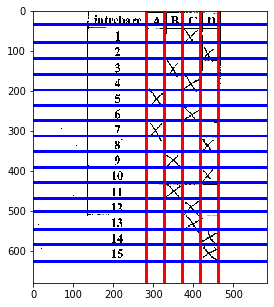

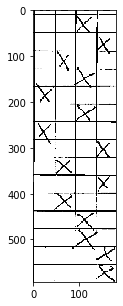

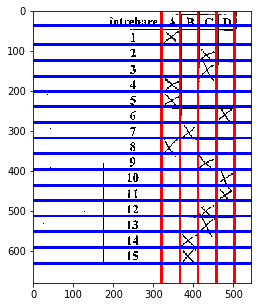

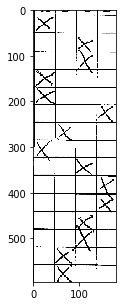

{1: 'C', 2: 'D', 3: 'B', 4: 'C', 5: 'A', 6: 'C', 7: 'A', 8: 'D', 9: 'B', 10: 'D', 11: 'B', 12: 'C', 13: 'C', 14: 'D', 15: 'D'}
{1: 'A', 2: 'C', 3: 'C', 4: 'A', 5: 'A', 6: 'D', 7: 'B', 8: 'A', 9: 'C', 10: 'D', 11: 'D', 12: 'C', 13: 'C', 14: 'B', 15: 'B'}


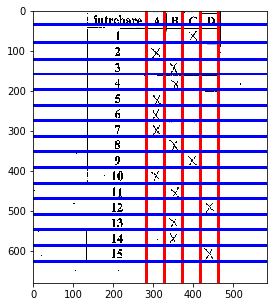

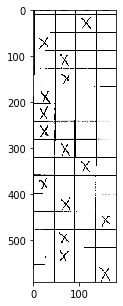

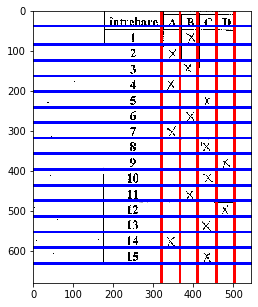

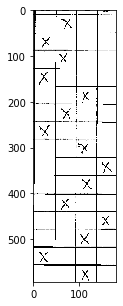

{1: 'C', 2: 'A', 3: 'B', 4: 'B', 5: 'A', 6: 'A', 7: 'A', 8: 'B', 9: 'C', 10: 'A', 11: 'B', 12: 'D', 13: 'B', 14: 'B', 15: 'D'}
{1: 'B', 2: 'A', 3: 'B', 4: 'A', 5: 'C', 6: 'B', 7: 'A', 8: 'C', 9: 'D', 10: 'C', 11: 'B', 12: 'D', 13: 'C', 14: 'A', 15: 'C'}


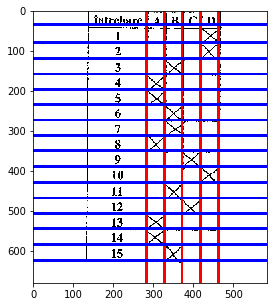

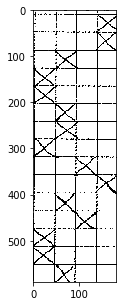

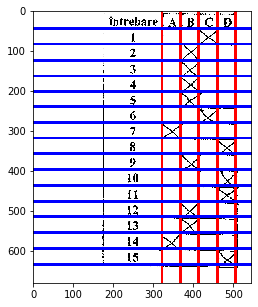

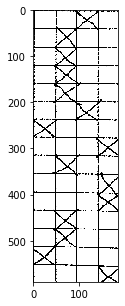

{1: 'D', 2: 'D', 3: 'B', 4: 'A', 5: 'A', 6: 'B', 7: 'B', 8: 'A', 9: 'C', 10: 'D', 11: 'B', 12: 'C', 13: 'A', 14: 'A', 15: 'B'}
{1: 'C', 2: 'B', 3: 'B', 4: 'B', 5: 'B', 6: 'C', 7: 'A', 8: 'D', 9: 'B', 10: 'D', 11: 'D', 12: 'B', 13: 'B', 14: 'A', 15: 'D'}


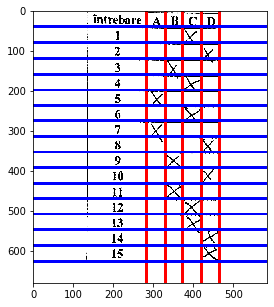

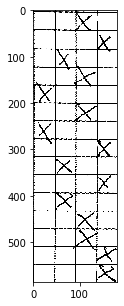

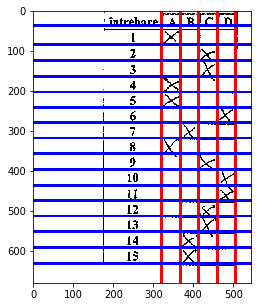

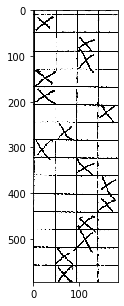

{1: 'C', 2: 'D', 3: 'B', 4: 'C', 5: 'A', 6: 'C', 7: 'A', 8: 'D', 9: 'B', 10: 'D', 11: 'B', 12: 'C', 13: 'C', 14: 'D', 15: 'D'}
{1: 'A', 2: 'C', 3: 'C', 4: 'A', 5: 'A', 6: 'D', 7: 'B', 8: 'A', 9: 'C', 10: 'D', 11: 'D', 12: 'C', 13: 'C', 14: 'B', 15: 'B'}


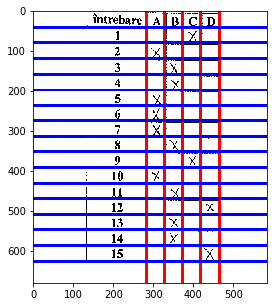

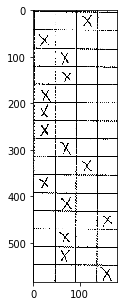

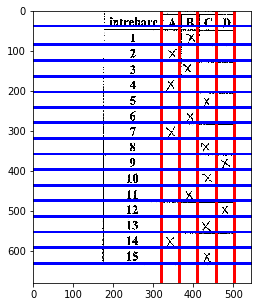

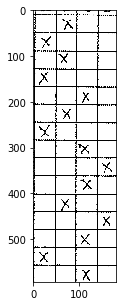

{1: 'C', 2: 'A', 3: 'B', 4: 'B', 5: 'A', 6: 'A', 7: 'A', 8: 'B', 9: 'C', 10: 'A', 11: 'B', 12: 'D', 13: 'B', 14: 'B', 15: 'D'}
{1: 'B', 2: 'A', 3: 'B', 4: 'A', 5: 'C', 6: 'B', 7: 'A', 8: 'C', 9: 'D', 10: 'C', 11: 'B', 12: 'D', 13: 'C', 14: 'A', 15: 'C'}


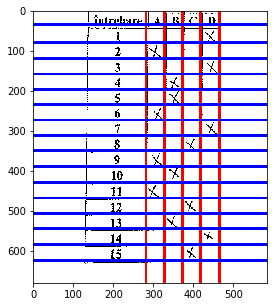

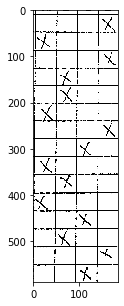

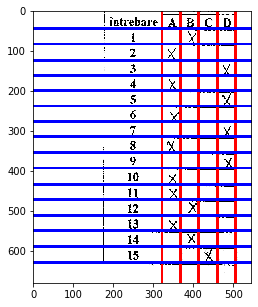

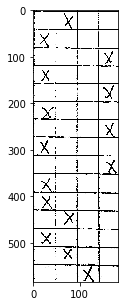

{1: 'D', 2: 'A', 3: 'D', 4: 'B', 5: 'B', 6: 'A', 7: 'D', 8: 'C', 9: 'A', 10: 'B', 11: 'A', 12: 'C', 13: 'B', 14: 'D', 15: 'C'}
{1: 'B', 2: 'A', 3: 'D', 4: 'A', 5: 'D', 6: 'A', 7: 'D', 8: 'A', 9: 'D', 10: 'A', 11: 'A', 12: 'B', 13: 'A', 14: 'B', 15: 'C'}


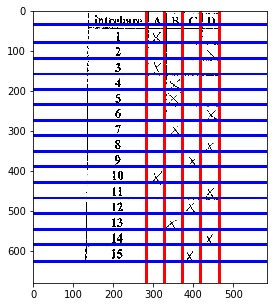

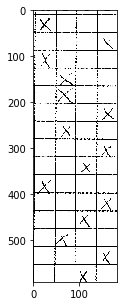

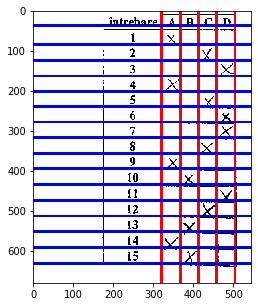

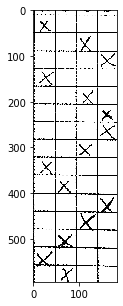

{1: 'A', 2: 'D', 3: 'A', 4: 'B', 5: 'B', 6: 'D', 7: 'B', 8: 'D', 9: 'C', 10: 'A', 11: 'D', 12: 'C', 13: 'B', 14: 'D', 15: 'C'}
{1: 'A', 2: 'C', 3: 'D', 4: 'A', 5: 'C', 6: 'D', 7: 'D', 8: 'C', 9: 'A', 10: 'B', 11: 'D', 12: 'C', 13: 'B', 14: 'A', 15: 'B'}


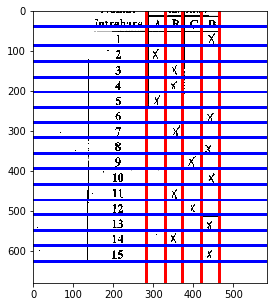

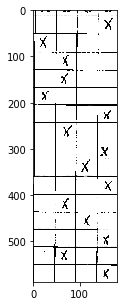

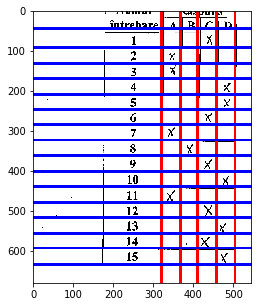

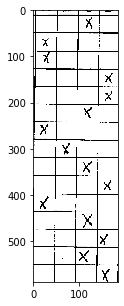

{1: 'D', 2: 'A', 3: 'B', 4: 'B', 5: 'A', 6: 'D', 7: 'B', 8: 'D', 9: 'C', 10: 'D', 11: 'B', 12: 'C', 13: 'D', 14: 'B', 15: 'D'}
{1: 'C', 2: 'A', 3: 'A', 4: 'D', 5: 'D', 6: 'C', 7: 'A', 8: 'B', 9: 'C', 10: 'D', 11: 'A', 12: 'C', 13: 'D', 14: 'C', 15: 'D'}


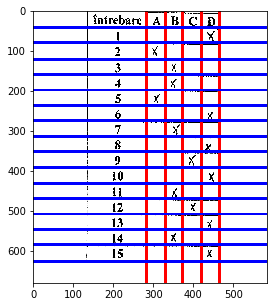

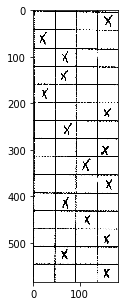

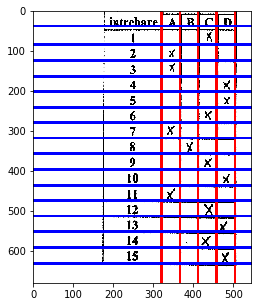

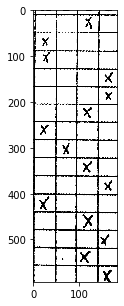

{1: 'D', 2: 'A', 3: 'B', 4: 'B', 5: 'A', 6: 'D', 7: 'B', 8: 'D', 9: 'C', 10: 'D', 11: 'B', 12: 'C', 13: 'D', 14: 'B', 15: 'D'}
{1: 'C', 2: 'A', 3: 'A', 4: 'D', 5: 'D', 6: 'C', 7: 'A', 8: 'B', 9: 'C', 10: 'D', 11: 'A', 12: 'C', 13: 'D', 14: 'C', 15: 'D'}


In [165]:
answers_left_ann, answers_right_ann, chosen_variant, subjects=answers_left_right_no_ann(no_ann_images, img_template_name)


Train data for CNN
----------

In [104]:
base_folder = 'digits/'
images_names = os.listdir(base_folder) 
num_images = len(images_names)
image_size = (28, 28)
images = []
labels = []
for image_name in images_names:
    im = cv.imread(os.path.join(base_folder, image_name))  
    im = cv.resize(im, image_size)
    im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    images.append(im)   
    label = int(image_name[0])
    labels.append(label)
images = np.array(images)
labels = np.array(labels) 

(126, 28, 28)
(126,)
(23, 28, 28)
(23,)


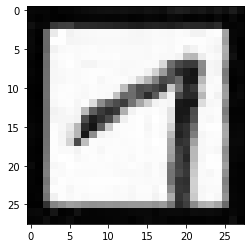

In [105]:
train_images, test_images, train_labels, test_labels  = train_test_split(images, labels, test_size=0.15, random_state=15)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
plt.imshow(train_images[0], cmap='gray' )
plt.show()

In [106]:
train_data=[]
for i in range(len(train_images)):
    train_data.append(train_images[i])
    
test_data=[]
for i in range(len(test_images)):
    test_data.append(test_images[i])

In [107]:
test_data=np.array(test_data)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)
train_data=np.array(train_data)
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
train_data /= 255
test_data /= 255

In [109]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
# compile model
opt = tf.keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#160 epochs inainte
model.fit(x=train_data,y=train_labels, epochs=160)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 126 samples
Epoch 1/160
126/126 [==============================] - 0s 1ms/sample - loss: 3.1334 - acc: 0.2302
Epoch 2/160
126/126 [==============================] - 0s 562us/sample - loss: 1.8101 - acc: 0.1905
Epoch 3/160
126/126 [==============================] - 0s 546us/sample - loss: 1.5146 - acc: 0.2063
Epoch 4/160
126/126 [==============================] - 0s 538us/sample - loss: 1.4607 - acc: 0.2460
Epoch 5/160
126/126 [==============================] - 0s 594us/sample - loss: 1.4614 - acc: 0.2698
Epoch 6/160
126/126 [==============================] - 0s 538us/sample - loss: 1.4399 - acc: 0.2937
Epoch 7/160
126/126 [==============================] - 0s 538us/sample - loss: 1.3300 - acc: 0.3968
Epoch 8/160
126/126 [==============================] - 0s 530us/sample - loss: 1.4041 - acc: 0.2619
Epoch 9/160
126/126 [==============================] - 0s 546us/sample - loss: 1.2921 - acc: 0.3968


126/126 [==============================] - 0s 538us/sample - loss: 0.0109 - acc: 0.9921
Epoch 159/160
126/126 [==============================] - 0s 539us/sample - loss: 0.0038 - acc: 1.0000
Epoch 160/160
126/126 [==============================] - 0s 554us/sample - loss: 0.0100 - acc: 1.0000


In [110]:
model.evaluate(test_data, test_labels)

23/23 [==============================] - 0s 1ms/sample - loss: 0.0878 - acc: 0.9565


[0.08778291940689087, 0.95652175]

Predictions
-------------

In [251]:
variant_list=[]
for i in range(len(chosen_variant)):
    grayscale_image1 = cv.cvtColor(chosen_variant[i], cv.COLOR_BGR2GRAY)
    grayscale_image1 = cv.resize(grayscale_image1, (28,28))
    blur=cv.GaussianBlur(grayscale_image1, (1,1),1)  
    variant_list.append(blur)

In [112]:
variant_list=np.array(variant_list)
variant_list = variant_list.reshape(variant_list.shape[0], 28, 28, 1)
variant_list = variant_list.astype('float32')
variant_list /= 255

In [117]:
model.load_weights("digits_prediction_model.h5")

In [169]:
pred = model.predict_classes(variant_list) 

In [170]:
pred

array([1, 1, 2, 1, 1, 3, 3, 2, 2], dtype=int64)

In [268]:
def calculate_grades_no_ann(images_names, subjects, digits, images_answers_left, images_answers_right, output_file_name, files_info, files_fizica):
    file = open(output_file_name, "w")
    print(digits)
    for i in range(len(images_names)):
        correct_answers=0
        ans_left_c=[]
        ans_right_c=[]
        
        if subjects[i]=='F':
            print(subjects[i])
            if digits[i]==1:
                ans_left_c=files_fizica[0][1:16]
                ans_right_c=files_fizica[0][16:-1]
            if digits[i]==2:
                ans_left_c=files_fizica[1][1:16]
                ans_right_c=files_fizica[1][16:-1]
            if digits[i]==3:
                ans_left_c=files_fizica[2][1:16]
                ans_right_c=files_fizica[2][16:-1]
            if digits[i]==4:
                ans_left_c=files_fizica[3][1:16]
                ans_right_c=files_fizica[3][16:-1]
        if subjects[i]=='I':
            if digits[i]==1:
                ans_left_c=files_info[0][1:16]
                ans_right_c=files_info[0][16:-1]
            if digits[i]==2:
                ans_left_c=files_info[1][1:16]
                ans_right_c=files_info[1][16:-1]
            if digits[i]==3:
                ans_left_c=files_info[2][1:16]
                ans_right_c=files_info[2][16:-1]
            if digits[i]==4:
                ans_left_c=files_info[3][1:16]
                ans_right_c=files_info[3][16:-1]

        print(ans_left_c)
        for j in range(len(images_answers_left[i])):
            if images_answers_left[i][j+1]==ans_left_c[j][1]:
                correct_answers+=1
        for j in range(len(images_answers_right[i])):
            if images_answers_right[i][j+1]==ans_right_c[j][1]:
                correct_answers+=1

        print('The number of correct answers from exam image %d are %d '%(i+1,correct_answers))
        grade=round(correct_answers*0.3+1,2)
        print('Grade: %5.2f'%(grade))
        file_name=images_names[i].split('\\')[-1]
        file.write(file_name + "  " + str(grade) + "\n")

    file.close()

In [269]:
calculate_grades_no_ann(no_ann_images, subjects, pred, answers_left_ann, answers_right_ann, 'task3.txt', files_info, files_fizica)

[1 1 2 1 1 3 3 2 2]
F
[['1' 'C']
 ['2' 'D']
 ['3' 'B']
 ['4' 'C']
 ['5' 'A']
 ['6' 'C']
 ['7' 'A']
 ['8' 'D']
 ['9' 'B']
 ['10' 'A']
 ['11' 'B']
 ['12' 'C']
 ['13' 'C']
 ['14' 'D']
 ['15' 'B']]
The number of correct answers from exam image 1 are 22 
Grade:  7.60
[['1' 'C']
 ['2' 'D']
 ['3' 'B']
 ['4' 'C']
 ['5' 'A']
 ['6' 'C']
 ['7' 'A']
 ['8' 'D']
 ['9' 'B']
 ['10' 'A']
 ['11' 'B']
 ['12' 'C']
 ['13' 'C']
 ['14' 'D']
 ['15' 'B']]
The number of correct answers from exam image 2 are 15 
Grade:  5.50
F
[['1' 'B']
 ['2' 'D']
 ['3' 'C']
 ['4' 'A']
 ['5' 'D']
 ['6' 'A']
 ['7' 'B']
 ['8' 'B']
 ['9' 'C']
 ['10' 'A']
 ['11' 'B']
 ['12' 'C']
 ['13' 'A']
 ['14' 'B']
 ['15' 'D']]
The number of correct answers from exam image 3 are 15 
Grade:  5.50
F
[['1' 'C']
 ['2' 'D']
 ['3' 'B']
 ['4' 'C']
 ['5' 'A']
 ['6' 'C']
 ['7' 'A']
 ['8' 'D']
 ['9' 'B']
 ['10' 'A']
 ['11' 'B']
 ['12' 'C']
 ['13' 'C']
 ['14' 'D']
 ['15' 'B']]
The number of correct answers from exam image 4 are 22 
Grade:  7.60
[['1' 'C']